<a href="https://colab.research.google.com/github/SammyGbabs/Time-Series-Forecasting/blob/main/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# **DESCRIPTIVE STATISTICS**

In [7]:
#Statistics of Dataset
train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


In [8]:
#Identifying Mising Value
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [9]:
#Skewness & Kurtosis
print("Skewness:", train['pm2.5'].skew())
print("Kurtosis:", train['pm2.5'].kurt())

Skewness: 1.8059885615490436
Kurtosis: 5.0973294897056824


In [10]:
#Percentile Analysis (Outliers Detection)
train['pm2.5'].quantile([0.01, 0.25, 0.5, 0.75, 0.99])

,pm2.5
0.01,7.0
0.25,29.0
0.50,75.0
0.75,142.0
0.99,429.0


# **Visiualizations Based on the Dataset**

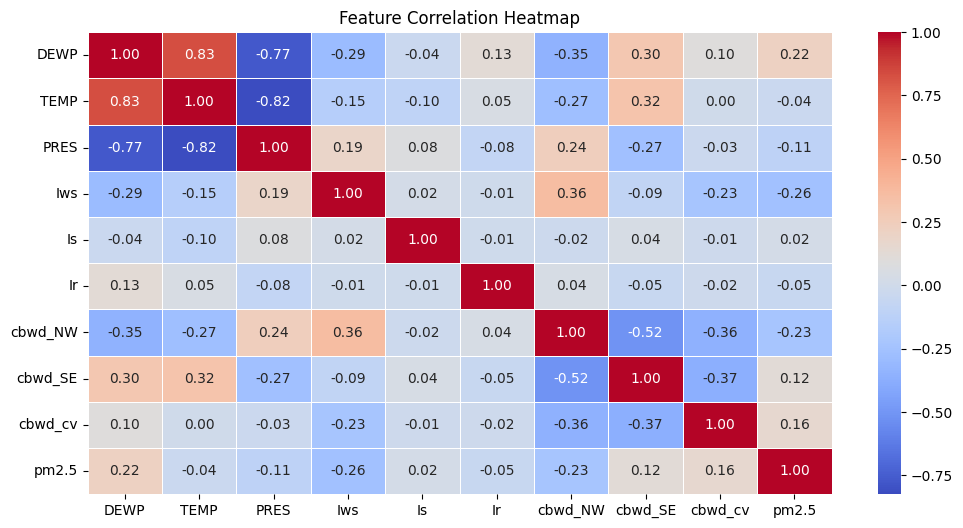

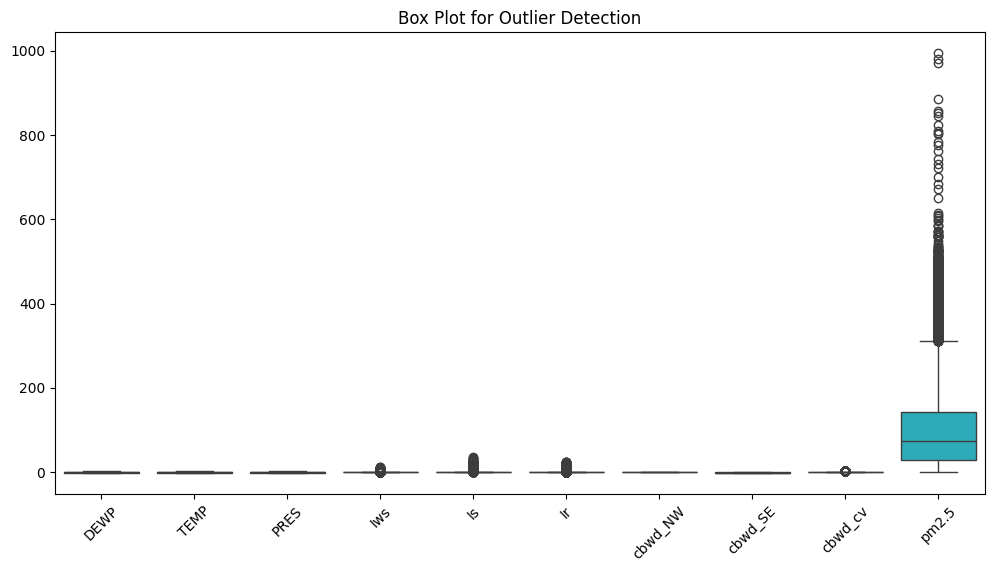

In [11]:
#HeatMap for the Dataset
# Computing the correlation matrix
corr_matrix = train.drop(columns=['No']).corr()  # Exclude non-numeric columns

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Plot boxplots for all numerical columns
plt.figure(figsize=(12, 6))
sns.boxplot(train.drop(columns=['No']))
plt.xticks(rotation=45)
plt.title("Box Plot for Outlier Detection")
plt.show()


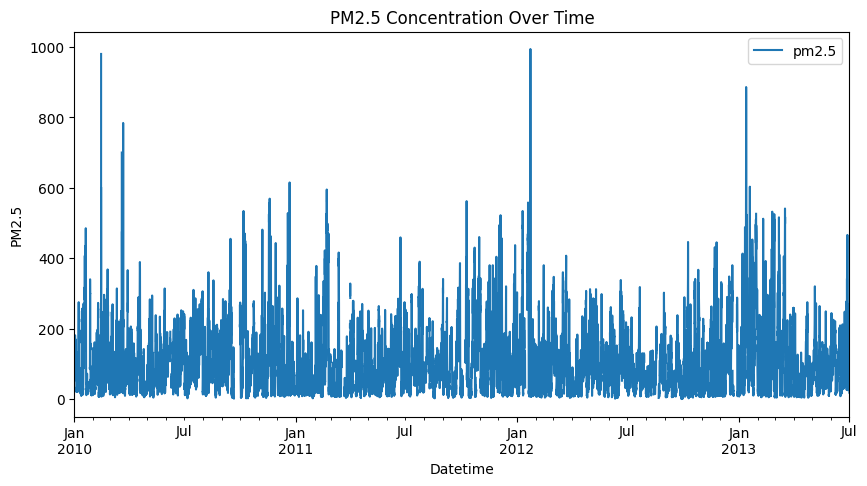

In [12]:
# Line Plot PM2.5 over time
train.plot(y='pm2.5', figsize=(10,5), title="PM2.5 Concentration Over Time")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.show()

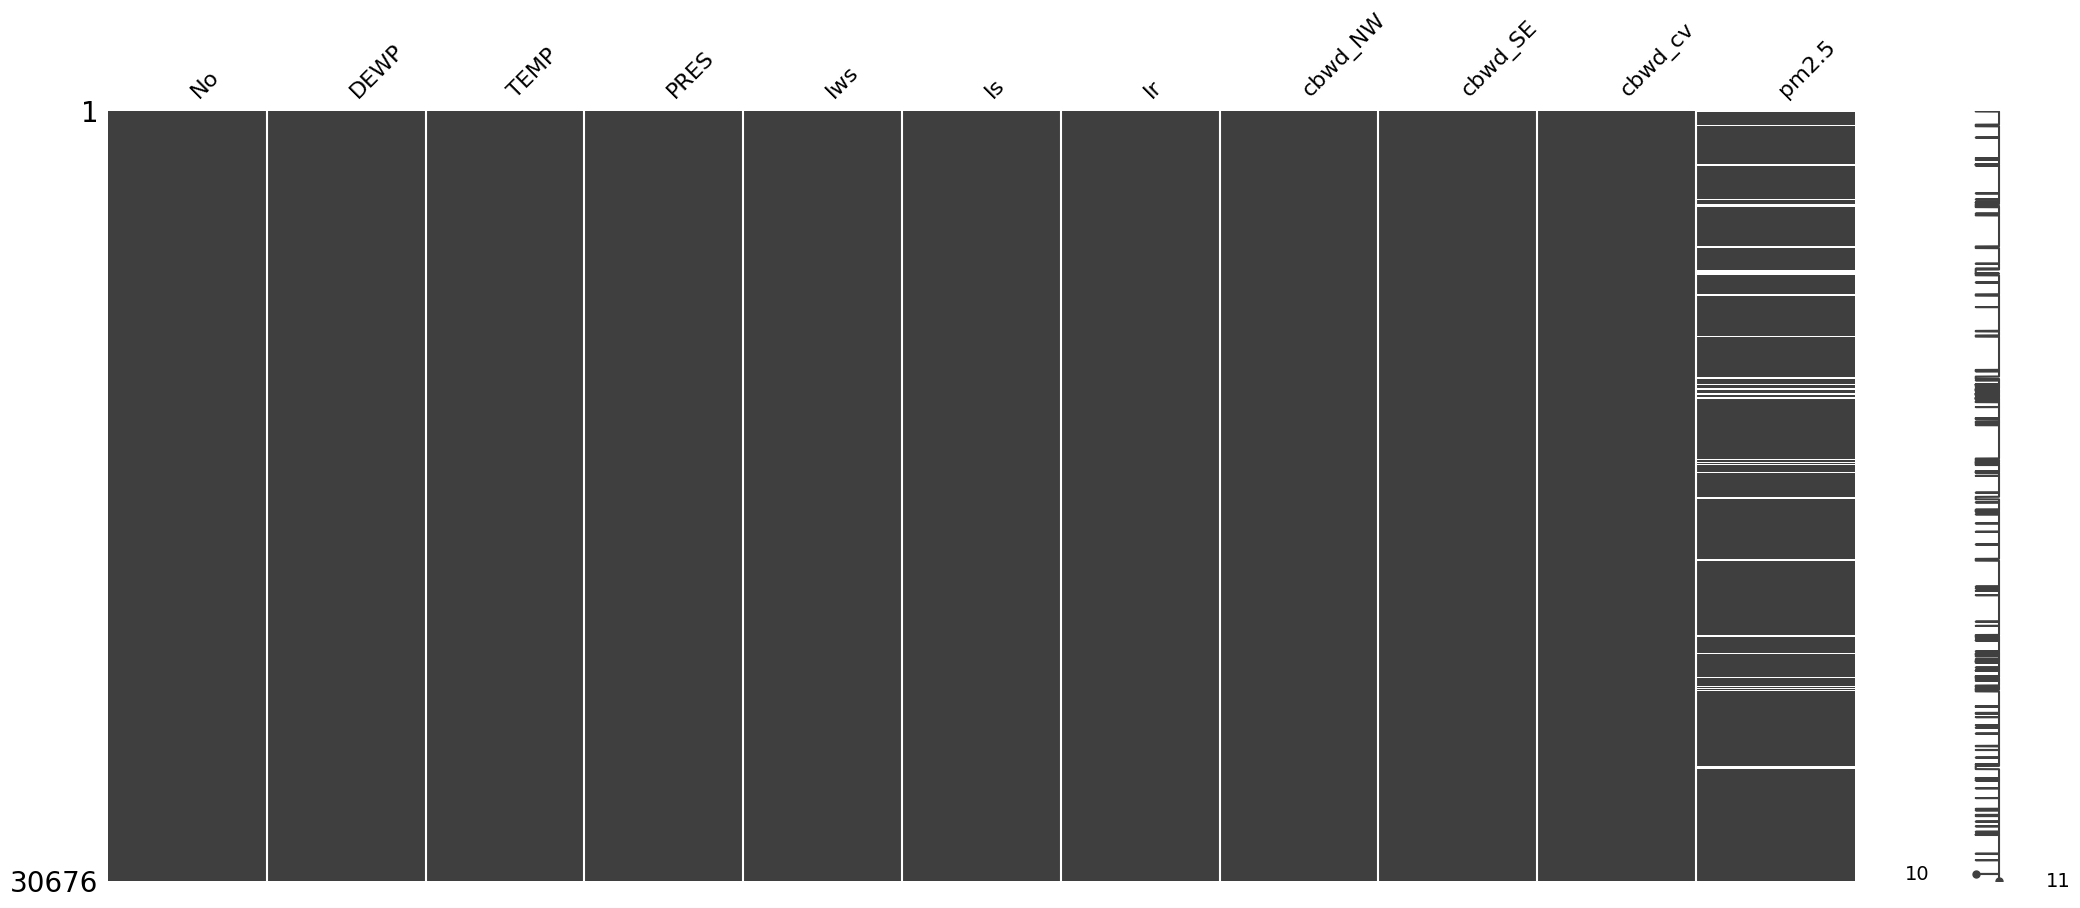

In [15]:
#Missing Value Heatmap
msno.matrix(train)
plt.show()

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

<ipython-input-16-e07a8d49b9da>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['pm2.5'] = train['pm2.5'].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


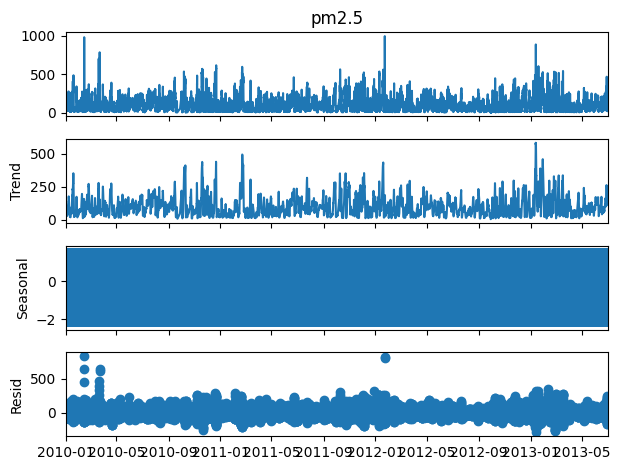

In [16]:
# Apply interpolation & forward-fill for missing values
# Ensure 'pm2.5' column is numeric
train['pm2.5'] = pd.to_numeric(train['pm2.5'], errors='coerce')

# Interpolate missing values and then forward-fill any remaining NaNs
train['pm2.5'] = train['pm2.5'].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

# Perform seasonal decomposition after ensuring no missing values
result = seasonal_decompose(train['pm2.5'], model='additive', period=30)

# Plot decomposition
result.plot()
plt.show()

# **TEMPORAL FEATURE ENGINEERING**

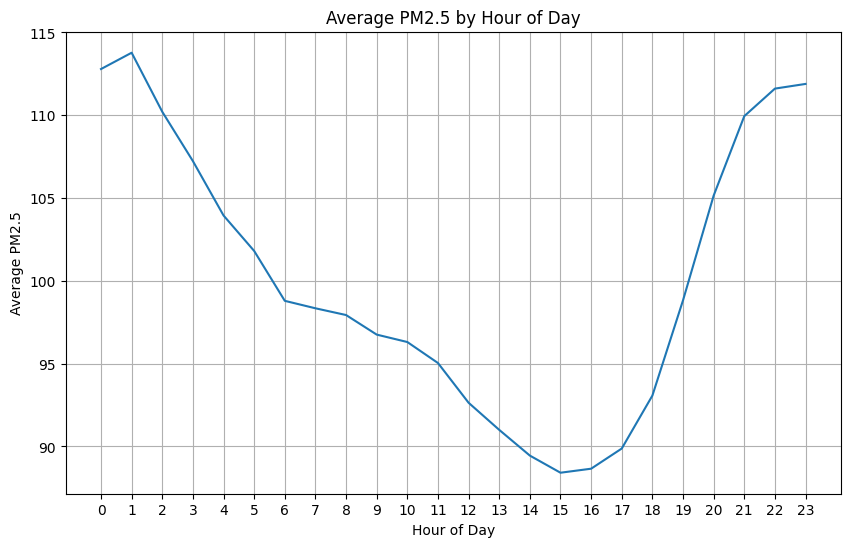

In [21]:
# Extract components from the datetime index
for df in [train, test]:
    df['hour'] = df.index.hour  # Access hour from the index
    df['day'] = df.index.day    # Access day from the index
    df['month'] = df.index.month  # Access month from the index
    df['weekday'] = df.index.weekday  # Access weekday from the index
    df['season'] = (df.index.month % 12 + 3) // 3  # Maps months to seasons using the index

plt.figure(figsize=(10, 6))
hourly_pm25 = train.groupby('hour')['pm2.5'].mean()
plt.plot(hourly_pm25)
plt.xlabel('Hour of Day')
plt.ylabel('Average PM2.5')
plt.title('Average PM2.5 by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# **NORMALIZATION**

In [22]:
# Separate features and target
X_train = train.drop(['pm2.5', 'No'], axis=1, errors='ignore')
y_train = train['pm2.5']

In [23]:
# Standardize features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)

# Standardize target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [24]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5', 'hour', 'day', 'month', 'weekday', 'season'],
      dtype='object')

In [25]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)

In [26]:
# Train-test split for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [27]:
# Enhanced LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    LSTM(32, activation='tanh', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile with RMSE as a monitored metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


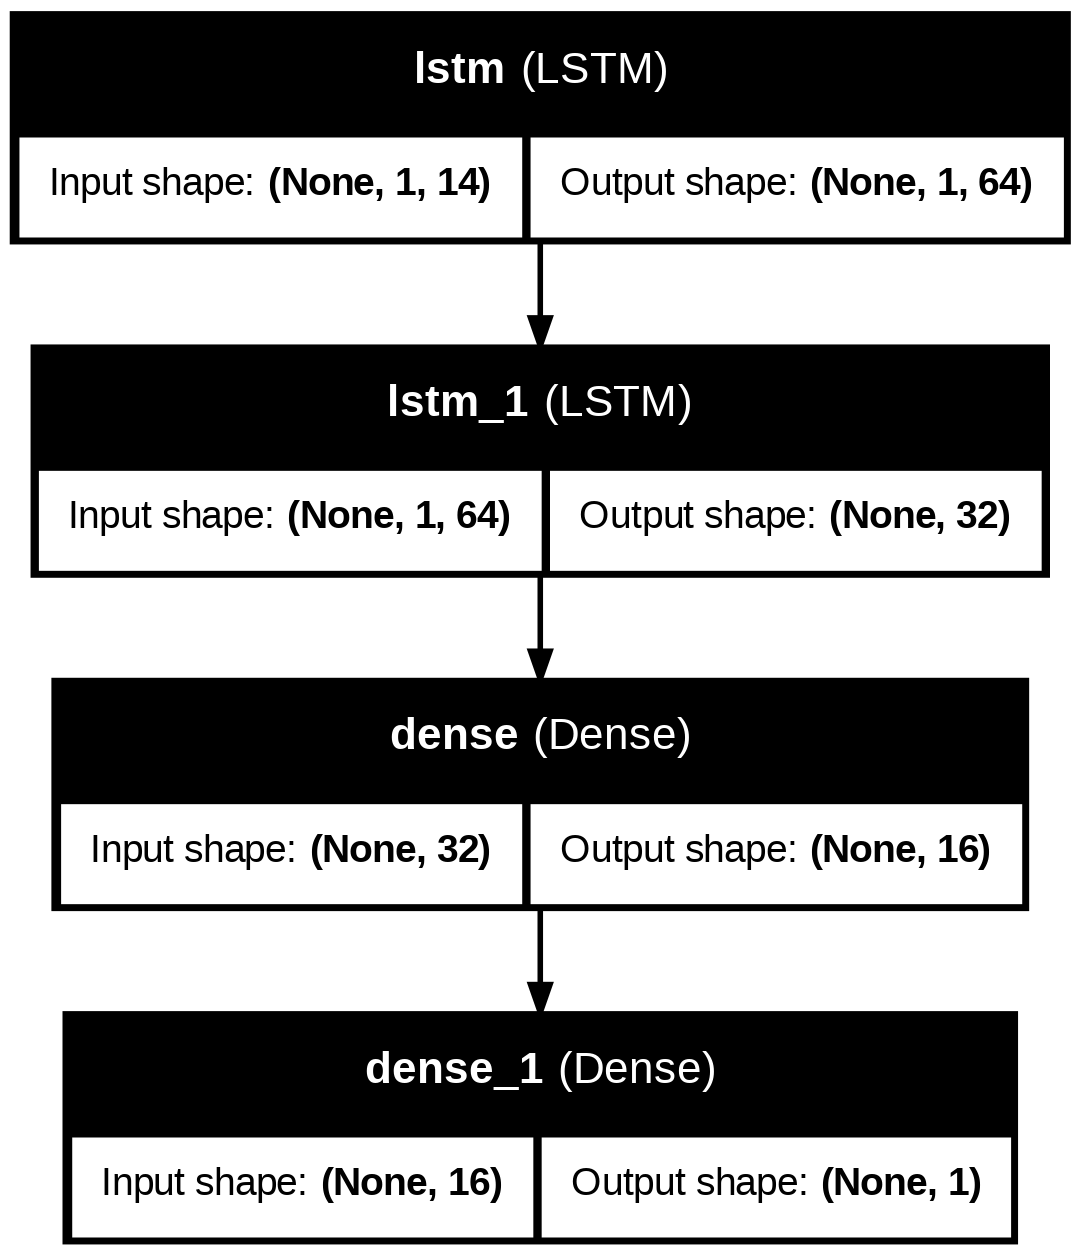

In [23]:
!apt-get install -y graphviz
!pip install pydot
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
# Display the saved model diagram
Image('model_architecture.png')


In [42]:
# Callbacks for early stopping and learning rate reduction
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7733 - rmse: 0.8773 - val_loss: 0.5753 - val_rmse: 0.7585 - learning_rate: 0.0010
Epoch 2/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5667 - rmse: 0.7526 - val_loss: 0.5376 - val_rmse: 0.7332 - learning_rate: 0.0010
Epoch 3/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.5159 - rmse: 0.7181 - val_loss: 0.5093 - val_rmse: 0.7137 - learning_rate: 0.0010
Epoch 4/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5183 - rmse: 0.7193 - val_loss: 0.4818 - val_rmse: 0.6941 - learning_rate: 0.0010
Epoch 5/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.4494 - rmse: 0.6702 - val_loss: 0.4329 - val_rmse: 0.6580 - learning_rate: 0.0010
Epoch 6/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4194 - rmse: 0.6472 - val_loss: 0.4392 - val_rmse: 0.6628 - learning_rate: 0.0010
Epoch 7/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4338 - rmse: 0.6586 - val_loss: 0.4158 - val_rmse: 0.6448 - learning_rate:

958/958 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


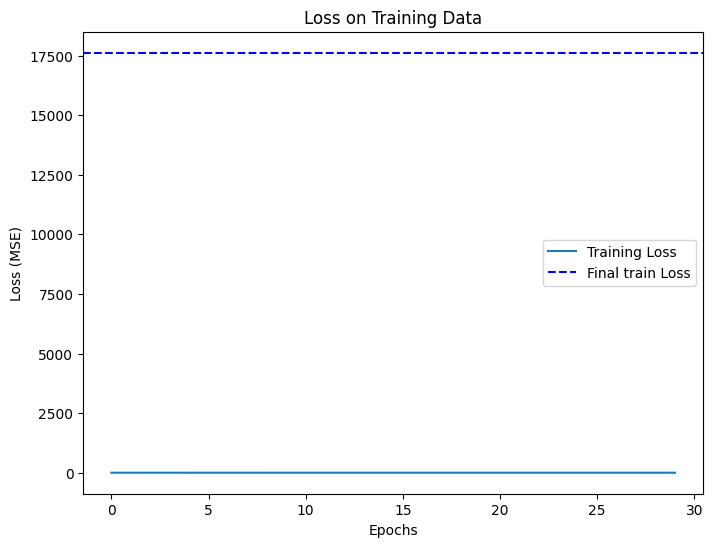

Final Training Loss (MSE): 17616.785507356057


In [43]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [46]:
# Prepare test data
X_test = test.drop(['No', 'pm2.5'], axis=1, errors='ignore')
X_test_scaled = scaler_x.transform(X_test)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test_scaled)

# Convert back to original scale
predictions = scaler_y.inverse_transform(predictions)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

predictions = np.clip(predictions, 0, np.max(predictions))  # Ensure no negative values

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)




411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
